## Objetivo:

O objetivo desta competição é desenvolver um modelo preditor do ELDT (Estimated Landing Time) para voos comerciais com origem e 
destino nos 12 principais aeródromos do Brasil, a saber:

- Brasília (SBBR)
- Confins (SBCF)
- Curitiba (SBCT)
- Florianópolis (SBFL)
- Rio de Janeiro - Galeão (SBGL)
- Guarulhos (SBGR)
- Campinas (SBKP)
- Porto Alegre (SBPA)
- Recife (SBRF)
- Rio de Janeiro - Santos Dumont (SBRJ)
- São Paulo - Congonhas (SBSP)
- Salvador (SBSV)

In [1]:
!pip install xgboost

import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import xgboost as xg

import requests
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
sns.set(style='white', context='notebook', palette='deep')

random.seed(1)

print(f'tf_version: {tf.__version__}')


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
2023-09-23 22:51:09.266754: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-23 22:51:09.428542: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-09-23 22:51:09.428575: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-09-23 22:51:09.460163: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory fo

## Funções auxiliares

In [2]:
# Função para carregar os dados da API

def get_data_from_API(base_name, idate, fdate, token='a779d04f85c4bf6cfa586d30aaec57c44e9b7173'):
    ''' base_name (string): nome da base, opcões: bimtra, cat-62, esperas, metaf, metar, satelite, tc-prev, tc-real
        idate (string): data inicial
        fdate (string): data final
        token (string): chave de acesso na API já está defaltada
    ''' 


    url = 'http://montreal.icea.decea.mil.br:5002/api/v1/' + base_name
    params = {
    'token': token,
    'idate': idate,
    'fdate': fdate
}

    headers = {'accept': 'application/json'}

    response = requests.get(url, params=params, headers=headers)

    if response.status_code == 200:
        base = response.json()
        print(f"Base {base_name} carregada com sucesso!")
        return pd.DataFrame(base)
    else:
        print(f"A solicitação falhou com status code {response.status_code}")

In [3]:
# Função para transformar datetime em int64

def datetime_to_int64(df, column):
    df[column] = pd.to_datetime(df[column], format='%Y-%m-%d %H:%M:%S.%f')
    df[column] = (df[column].astype(int) / 10**6) #.astype('datetime64[ms]')
    return df

# Função para transformar int64 em datetime

def int64_to_datetime(data, column=None):
    if column is None:
        # Se 'column' não for especificado, assumimos que 'data' é uma Series
        return data.astype('datetime64[ms]')
    else:
        # Se 'column' for especificado, assumimos que 'data' é um DataFrame
        data[column] = data[column].astype('datetime64[ms]')
        return data

In [4]:
# Setar datas para pegar dados da API
data_inicial = "2022-06-01"
data_final = "2023-05-13"

# Carregar o dataset BIMTRA

"""

A base de dados BIMTRA possui informações dos movimentos nos aeródromos do Brasil. Assim, é possível encontrar 
dados como hora de decolagem estimada, origem, destino, tempo de voo previsto, etc. Para o problema em questão, 
uma versão resumida do BIMTRA será fornecida, contendo os seguintes campos:

FlightID (Identificador único de um voo)
Origem (Código ICAO do Aeroporto de Origem do voo)
Destino (Código ICAO do Aeroporto de Destino do voo)
Hora_Dep (Data/Hora de Decolagem do voo)
Hora_Arr (Data/Hora de Pouso do voo)

O campo Hora_Arr corresponde ao atributo alvo do desafio proposto, isto é, o modelo desenvolvido por cada equipe 
deverá estimar os valores de Hora_Arr. Tomem cuidado com data leakage, ou seja, construindo modelos com informações do futuro.


"""


BIMTRA_df = get_data_from_API('bimtra', data_inicial, data_final)
display(BIMTRA_df)


Base bimtra carregada com sucesso!


,flightid,origem,destino,dt_dep,dt_arr
0,fcb2bf90345705318213ae1307c0f901,SBKP,SBRJ,1654044297000,1654046760000
1,c7c5c10716335b048f86d8c52fcba3f2,SBGR,SBRJ,1654045021000,1654047173000
2,3162de7203a972f071d5a48e8f0f4828,SBBR,SBRJ,1654043212000,1654047825000
3,8fcd243e9b9eebbe62ab145ce04b6ab5,SBKP,SBCF,1654045120000,1654047701000
4,504a62621cd231d6ab67e674ce538cd3,SBCF,SBFL,1654045238000,1654050785000
...,...,...,...,...,...
300342,c4321a6a09b76969df53965fb5390f12,SBBR,SBRF,1683980059000,1683987623000
300343,e4f5686cce45083566945c8946e5d120,SBBR,SBGR,1683970395000,1683975521000
300344,04f65a7c44cf176215520b4c9b4eb37f,SBCF,SBRF,1683996833000,1684004424000
300345,f72a0718e581d01c695faeeff35d81f0,SBSV,SBGR,1683955738000,1683964481000


In [5]:
esperas_df = get_data_from_API('esperas', data_inicial, data_final)
tc_prev_df = get_data_from_API('tc-prev', data_inicial, data_final)
tc_real_df = get_data_from_API('tc-real', data_inicial, data_final)

Base esperas carregada com sucesso!
Base tc-prev carregada com sucesso!
Base tc-real carregada com sucesso!


In [6]:
metar_df = get_data_from_API("metar", data_inicial, data_final)
metaf_df = get_data_from_API("metaf", data_inicial, data_final)

Base metar carregada com sucesso!
Base metaf carregada com sucesso!


In [7]:
# Cálculo do ELDT 
# ELDT = (pd.to_datetime(BIMTRA_df.dt_arr) - pd.to_datetime(BIMTRA_df.dt_dep)).dt.total_seconds()
ELDT = BIMTRA_df['dt_arr'] - BIMTRA_df['dt_dep']
BIMTRA_df['eldt'] = ELDT
BIMTRA_df

,flightid,origem,destino,dt_dep,dt_arr,eldt
0,fcb2bf90345705318213ae1307c0f901,SBKP,SBRJ,1654044297000,1654046760000,2463000
1,c7c5c10716335b048f86d8c52fcba3f2,SBGR,SBRJ,1654045021000,1654047173000,2152000
2,3162de7203a972f071d5a48e8f0f4828,SBBR,SBRJ,1654043212000,1654047825000,4613000
3,8fcd243e9b9eebbe62ab145ce04b6ab5,SBKP,SBCF,1654045120000,1654047701000,2581000
4,504a62621cd231d6ab67e674ce538cd3,SBCF,SBFL,1654045238000,1654050785000,5547000
...,...,...,...,...,...,...
300342,c4321a6a09b76969df53965fb5390f12,SBBR,SBRF,1683980059000,1683987623000,7564000
300343,e4f5686cce45083566945c8946e5d120,SBBR,SBGR,1683970395000,1683975521000,5126000
300344,04f65a7c44cf176215520b4c9b4eb37f,SBCF,SBRF,1683996833000,1684004424000,7591000
300345,f72a0718e581d01c695faeeff35d81f0,SBSV,SBGR,1683955738000,1683964481000,8743000


# 1. Tratamento de Dados

## 1.1 Células vazias e duplicadas

In [8]:
# Checagem de células vazias
display(pd.DataFrame(BIMTRA_df.isnull().sum(), columns=['Nº Células Vazias']))

# Checagem de células duplicadas
print('Número de duplicatas: ', BIMTRA_df.duplicated().sum())
BIMTRA_df_adjusted = BIMTRA_df.drop_duplicates(inplace=False)

,Nº Células Vazias
flightid,0
origem,0
destino,0
dt_dep,0
dt_arr,0
eldt,0


Número de duplicatas:  13312


In [9]:
print('Número de duplicatas após eliminação: ', BIMTRA_df_adjusted.duplicated().sum())

Número de duplicatas após eliminação:  0


In [10]:
# Checagem de células vazias
display(pd.DataFrame(tc_prev_df.isnull().sum(), columns=['Nº Células Vazias']))

# Checagem de células duplicadas
print('Número de duplicatas: ', tc_prev_df.duplicated().sum())
tc_prev_df_adjusted = tc_prev_df.drop_duplicates(inplace=False)

,Nº Células Vazias
hora,0
troca,0
aero,0


Número de duplicatas:  0


In [11]:
# Checagem de células vazias
display(pd.DataFrame(tc_real_df.isnull().sum(), columns=['Nº Células Vazias']))

# Checagem de células duplicadas
print('Número de duplicatas: ', tc_real_df.duplicated().sum())
tc_real_df_adjusted = tc_real_df.drop_duplicates(inplace=False)

,Nº Células Vazias
hora,0
nova_cabeceira,0
antiga_cabeceira,0
aero,0


Número de duplicatas:  0


In [12]:
# Checagem de células vazias
display(pd.DataFrame(esperas_df.isnull().sum(), columns=['Nº Células Vazias']))

# Checagem de células duplicadas
print('Número de duplicatas: ', esperas_df.duplicated().sum())
esperas_df_adjusted = esperas_df.drop_duplicates(inplace=False)

,Nº Células Vazias
esperas,0
hora,0
aero,0


Número de duplicatas:  0


## 1.2 Valores negativos

In [13]:
# Máscara booleana das linhas <= 0
mask = BIMTRA_df_adjusted['eldt'] <= 0

print('Número de linhas onde ELDT <= 0: ', BIMTRA_df_adjusted[mask].values.shape[0])
display(BIMTRA_df_adjusted[mask])

# Remove as linhas
BIMTRA_df_adjusted = BIMTRA_df_adjusted[~mask]

Número de linhas onde ELDT <= 0:  362


,flightid,origem,destino,dt_dep,dt_arr,eldt
959,8b3f12d8ed9e058f3376775871eedb0b,SBRF,SBGR,1654155636000,1654154272000,-1364000
1293,aef3f7cf8b6978a497133ea80e0c86fc,SBSP,SBFL,1654190114000,1654187529000,-2585000
1550,310b5374273eb182ca50015a2563ac65,SBRJ,SBSP,1654300104000,1654298716000,-1388000
1619,49d1f882d1db81ea17aa7854b0e5fab9,SBRJ,SBSP,1654300104000,1654216563000,-83541000
1620,8d8998b8f3da5d2367b6b5ce84258ead,SBRJ,SBSP,1654298696000,1654216563000,-82133000
...,...,...,...,...,...,...
292859,681c4e7e7a0710fdea94ca040e5601c5,SBRJ,SBCT,1683286282000,1683285726000,-556000
293000,c53dab3a854660c840f02407bae7b5ad,SBGR,SBCT,1683321682000,1683252992000,-68690000
296362,9920fdcf556e30604a74118aac038de2,SBKP,SBCF,1683666837000,1683660378000,-6459000
297917,476fab74550f6747dc753b167e044a6a,SBRJ,SBFL,1683811190000,1683807345000,-3845000


## 1.3 Alterar colunas e juntar os dados

Vamos arredondar as horas para baixo numa nova coluna para ser usada como referência quando for juntar dataframes diferentes que precisam se identificar pelas horas. Para tal, utilizamos o método floor passando o "H" de horas como parâmetro.

In [14]:
hora_ref = BIMTRA_df_adjusted['dt_dep']# Valores em int64 
hora_ref = int64_to_datetime(hora_ref) # Transformando series em datetime
hora_ref = hora_ref.dt.floor('H') # Aproximando horas para baixo
BIMTRA_df_adjusted['hora_ref'] = hora_ref # Adicionando nova coluna

BIMTRA_df_adjusted['hora_ref']

0        2022-06-01 00:00:00
1        2022-06-01 00:00:00
2        2022-06-01 00:00:00
3        2022-06-01 00:00:00
4        2022-06-01 01:00:00
                 ...        
300342   2023-05-13 12:00:00
300343   2023-05-13 09:00:00
300344   2023-05-13 16:00:00
300345   2023-05-13 05:00:00
300346   2023-05-13 09:00:00
Name: hora_ref, Length: 286673, dtype: datetime64[ns]

### Previsão de troca de cabeceiras

In [15]:
# Previsão de mudança de cabeceiras
display(tc_prev_df.head())

,hora,troca,aero
0,1654041600000,0,BR
1,1654045200000,0,BR
2,1654048800000,0,BR
3,1654052400000,0,BR
4,1654056000000,0,BR


Mudar os dados da coluna "hora" para datetime. Assim, analisaremos melhor e será mais fácil para arredondar para um horario específico para o merge dos dataframes no futuro. Também vamos adicionar SB antes de todas as células da coluna "aero", para poder ficar igual a base BIMTRA.

In [19]:
tc_real_to_merge = tc_real_df_adjusted.copy()

# Data e hora
tc_real_to_merge = int64_to_datetime(tc_real_to_merge, 'hora')
tc_real_to_merge.rename(columns={'hora': 'hora_tcr'}, inplace=True)

tc_real_to_merge['hora_tcr'] = tc_real_to_merge['hora_tcr'].dt.floor('H')
print("Duplicatas após aproximação das horas:", tc_real_to_merge.duplicated().sum())

# Adicionar SB antes dos nomes na coluna aero 
tc_real_to_merge['destino'] =  'SB' + tc_real_to_merge['aero'].str[0:2]
tc_real_to_merge.drop(['aero'], axis=1, inplace=True)

# Dropar colunas "nova_cabeeceira" e "antiga_cabeceira"
tc_real_to_merge.drop(['nova_cabeceira', 'antiga_cabeceira'], axis=1, inplace=True)

print("Duplicatas após eliminação de colunas das cabeceiras:", tc_real_to_merge.duplicated().sum())

# Remover linhas duplicadas
tc_real_to_merge = tc_real_to_merge.drop_duplicates(inplace=False)

# Adicionar coluna de 1's para poder identificar quais vôos obtiveram a troca de cabeceiras após merge
tc_real_to_merge['troca_efetivada'] = 1

tc_real_to_merge

Duplicatas após aproximação das horas: 4752
Duplicatas após eliminação de colunas das cabeceiras: 13543


,hora_tcr,destino,troca_efetivada
0,2022-06-01 14:00:00,SBFL,1
1,2022-06-01 18:00:00,SBRF,1
2,2022-06-01 19:00:00,SBCF,1
3,2022-06-01 19:00:00,SBGL,1
5,2022-06-01 19:00:00,SBFL,1
...,...,...,...
33424,2023-05-13 20:00:00,SBGL,1
33425,2023-05-13 15:00:00,SBRJ,1
33427,2023-05-13 22:00:00,SBSP,1
33428,2023-05-13 15:00:00,SBCT,1


### Troca de cabeceiras observadas

In [18]:
# Mudança de cabeceiras observadas
display(tc_real_df_adjusted)

,hora,nova_cabeceira,antiga_cabeceira,aero
0,1654092843000,32,03,FL
1,1654109470000,18,12,RF
2,1654110745000,16,13,CF
3,1654110758000,15,26,GL
4,1654110777000,15,26,GL
...,...,...,...,...
33426,1683991948000,14,08,FL
33427,1684015596000,17R,12,SP
33428,1683992504000,15,26,CT
33429,1684017668000,17R,12,SP


In [16]:
tc_prev_to_merge = tc_prev_df_adjusted.copy()

# Data e hora

tc_prev_to_merge

int64_to_datetime(tc_prev_to_merge, 'hora')
tc_prev_to_merge.rename(columns={'hora': 'hora_tcp'}, inplace=True)

# Adicionar SB antes dos nomes na coluna aero 
tc_prev_to_merge['aero'] =  'SB' + tc_prev_to_merge['aero']
tc_prev_to_merge.rename(columns={'aero': 'destino'}, inplace=True)

tc_prev_to_merge

,hora_tcp,troca,destino
0,2022-06-01 00:00:00,0,SBBR
1,2022-06-01 01:00:00,0,SBBR
2,2022-06-01 02:00:00,0,SBBR
3,2022-06-01 03:00:00,0,SBBR
4,2022-06-01 04:00:00,0,SBBR
...,...,...,...
99931,2023-05-13 19:00:00,0,SBSV
99932,2023-05-13 20:00:00,0,SBSV
99933,2023-05-13 21:00:00,0,SBSV
99934,2023-05-13 22:00:00,0,SBSV


In [17]:
BIMTRA_tc = BIMTRA_df_adjusted.copy()

# Criar coluna para ser usada para merge dos dataframes
BIMTRA_tc['hora_tcp'] = BIMTRA_tc['hora_ref'] + pd.Timedelta(hours=1)

BIMTRA_tc = pd.merge(BIMTRA_tc, tc_prev_to_merge, on=['destino', 'hora_tcp'], how='left')

display(BIMTRA_tc)

,flightid,origem,destino,dt_dep,dt_arr,eldt,hora_ref,hora_tcp,troca
0,fcb2bf90345705318213ae1307c0f901,SBKP,SBRJ,1654044297000,1654046760000,2463000,2022-06-01 00:00:00,2022-06-01 01:00:00,0.0
1,c7c5c10716335b048f86d8c52fcba3f2,SBGR,SBRJ,1654045021000,1654047173000,2152000,2022-06-01 00:00:00,2022-06-01 01:00:00,0.0
2,3162de7203a972f071d5a48e8f0f4828,SBBR,SBRJ,1654043212000,1654047825000,4613000,2022-06-01 00:00:00,2022-06-01 01:00:00,0.0
3,8fcd243e9b9eebbe62ab145ce04b6ab5,SBKP,SBCF,1654045120000,1654047701000,2581000,2022-06-01 00:00:00,2022-06-01 01:00:00,0.0
4,504a62621cd231d6ab67e674ce538cd3,SBCF,SBFL,1654045238000,1654050785000,5547000,2022-06-01 01:00:00,2022-06-01 02:00:00,0.0
...,...,...,...,...,...,...,...,...,...
286668,c4321a6a09b76969df53965fb5390f12,SBBR,SBRF,1683980059000,1683987623000,7564000,2023-05-13 12:00:00,2023-05-13 13:00:00,0.0
286669,e4f5686cce45083566945c8946e5d120,SBBR,SBGR,1683970395000,1683975521000,5126000,2023-05-13 09:00:00,2023-05-13 10:00:00,0.0
286670,04f65a7c44cf176215520b4c9b4eb37f,SBCF,SBRF,1683996833000,1684004424000,7591000,2023-05-13 16:00:00,2023-05-13 17:00:00,0.0
286671,f72a0718e581d01c695faeeff35d81f0,SBSV,SBGR,1683955738000,1683964481000,8743000,2023-05-13 05:00:00,2023-05-13 06:00:00,0.0


Vamos juntar os dados da previsão da troca de cabeceiras com os dados BIMTRA, através hora após a decolagem e no aeroporto de destino especifico

Os números das cabeceiras variam de 01 a 36, sempre com dois dígitos. Quando a cabeceira tem o número 27, significa que durante os pousos e decolagens a bússola marca 270°. No Santos Dumont, no Rio de Janeiro, os números são 02 e 20, enquanto Congonhas usa 17 e 35. Quando há duas pistas paralelas em um mesmo aeroporto, as cabeceiras têm os mesmos números, já que estão na mesma direção. Por conta disso, ganham as letras L ou R para diferenciar as pistas da esquerda (left) e da direita (right) na visão do piloto. Se houver três pistas paralelas, a central ganha a letra C (center).

Se, durante o voo, as condições meteorológicas ou outros fatores mudarem de tal forma que seja mais seguro ou eficiente usar uma pista de pouso diferente da planejada inicialmente, a torre de controle e a tripulação de voo podem tomar a decisão de trocar de cabeceira. Isso geralmente ocorre antes da aeronave se aproximar do aeroporto.

In [20]:
BIMTRA_cabeceiras = BIMTRA_tc.copy()

BIMTRA_cabeceiras['hora_tcr'] = pd.to_datetime(BIMTRA_tc['dt_dep'], unit='ms')

BIMTRA_cabeceiras['hora_tcr'] = BIMTRA_cabeceiras['hora_tcr'].dt.floor('H')

# Realizar a concatenação dos dataframes
BIMTRA_cabeceiras = pd.merge(BIMTRA_cabeceiras, tc_real_to_merge, on=['destino', 'hora_tcr'], how='left')

# Preenchar valores nan que nao tiveram match no merge, logo não tiveram troca de cabeceira observada
BIMTRA_cabeceiras['troca_efetivada'].fillna(0, inplace=True)

BIMTRA_cabeceiras

,flightid,origem,destino,dt_dep,dt_arr,eldt,hora_ref,hora_tcp,troca,hora_tcr,troca_efetivada
0,fcb2bf90345705318213ae1307c0f901,SBKP,SBRJ,1654044297000,1654046760000,2463000,2022-06-01 00:00:00,2022-06-01 01:00:00,0.0,2022-06-01 00:00:00,0.0
1,c7c5c10716335b048f86d8c52fcba3f2,SBGR,SBRJ,1654045021000,1654047173000,2152000,2022-06-01 00:00:00,2022-06-01 01:00:00,0.0,2022-06-01 00:00:00,0.0
2,3162de7203a972f071d5a48e8f0f4828,SBBR,SBRJ,1654043212000,1654047825000,4613000,2022-06-01 00:00:00,2022-06-01 01:00:00,0.0,2022-06-01 00:00:00,0.0
3,8fcd243e9b9eebbe62ab145ce04b6ab5,SBKP,SBCF,1654045120000,1654047701000,2581000,2022-06-01 00:00:00,2022-06-01 01:00:00,0.0,2022-06-01 00:00:00,0.0
4,504a62621cd231d6ab67e674ce538cd3,SBCF,SBFL,1654045238000,1654050785000,5547000,2022-06-01 01:00:00,2022-06-01 02:00:00,0.0,2022-06-01 01:00:00,0.0
...,...,...,...,...,...,...,...,...,...,...,...
286668,c4321a6a09b76969df53965fb5390f12,SBBR,SBRF,1683980059000,1683987623000,7564000,2023-05-13 12:00:00,2023-05-13 13:00:00,0.0,2023-05-13 12:00:00,0.0
286669,e4f5686cce45083566945c8946e5d120,SBBR,SBGR,1683970395000,1683975521000,5126000,2023-05-13 09:00:00,2023-05-13 10:00:00,0.0,2023-05-13 09:00:00,0.0
286670,04f65a7c44cf176215520b4c9b4eb37f,SBCF,SBRF,1683996833000,1684004424000,7591000,2023-05-13 16:00:00,2023-05-13 17:00:00,0.0,2023-05-13 16:00:00,0.0
286671,f72a0718e581d01c695faeeff35d81f0,SBSV,SBGR,1683955738000,1683964481000,8743000,2023-05-13 05:00:00,2023-05-13 06:00:00,0.0,2023-05-13 05:00:00,0.0


In [21]:
num_trocas_observ = BIMTRA_cabeceiras['troca_efetivada'].count()
num_voos_diferentes = BIMTRA_cabeceiras['flightid'].nunique()
trocas_prev = BIMTRA_cabeceiras[BIMTRA_cabeceiras['troca']==1].count() 
num_trocas_prev = trocas_prev.iloc[0]
trocas_acertadas = len(BIMTRA_cabeceiras[(BIMTRA_cabeceiras['troca'] == 1) & (BIMTRA_cabeceiras['troca_efetivada'] == 1)])

print("Numero de voos com trocas observadas:", num_trocas_observ)
print("Numero de voos com trocas previstas:", num_trocas_prev)
print("Numero de voos com trocas previstas corretamente:", trocas_acertadas)

print("Numero de voos diferentes:", num_voos_diferentes)
print("Numero de voos duplicados:", BIMTRA_cabeceiras.flightid.duplicated().sum())

Numero de voos com trocas observadas: 286673
Numero de voos com trocas previstas: 85115
Numero de voos com trocas previstas corretamente: 22823
Numero de voos diferentes: 286673
Numero de voos duplicados: 0


### Esperas

In [22]:
esperas_df_adjusted.head()

,esperas,hora,aero
0,0,1654041600000,SBBR
1,0,1654045200000,SBBR
2,0,1654048800000,SBBR
3,0,1654052400000,SBBR
4,0,1654056000000,SBBR


In [23]:
esperas_to_merge = esperas_df_adjusted.copy()

# Data e hora
int64_to_datetime(esperas_to_merge, 'hora')
esperas_to_merge.rename(columns={'hora': 'hora_esperas'}, inplace=True)

esperas_to_merge.rename(columns={'aero': 'destino'}, inplace=True)
esperas_to_merge

,esperas,hora_esperas,destino
0,0,2022-06-01 00:00:00,SBBR
1,0,2022-06-01 01:00:00,SBBR
2,0,2022-06-01 02:00:00,SBBR
3,0,2022-06-01 03:00:00,SBBR
4,0,2022-06-01 04:00:00,SBBR
...,...,...,...
99931,0,2023-05-13 19:00:00,SBSV
99932,0,2023-05-13 20:00:00,SBSV
99933,0,2023-05-13 21:00:00,SBSV
99934,0,2023-05-13 22:00:00,SBSV


Fazer alterações similares as feitas ao dataset das previsões de trocas de cabeceiras. Entretando, este tem as trocas que realmente aconteceram (obeservadas). Ele possui colunas com informação sobre quais cabeceiras serão alteradas, as quais não iremos precisar para nosso modelo. Duplicatas irão surgir pois temos linhas com destino e hora repetidas por conta de diferentes cabeceiras trocadas para um determinado horário num determinado aeroporto. Assim, devemos excluí-las.

Juntar os dados da previsão das trocas de cabeceiras observadas com os demais

In [24]:
BIMTRA_cabeceiras_esperas = BIMTRA_cabeceiras.copy()

BIMTRA_cabeceiras_esperas['hora_esperas'] = BIMTRA_cabeceiras_esperas['hora_ref'] - pd.Timedelta(hours=1)

BIMTRA_cabeceiras_esperas = pd.merge(BIMTRA_cabeceiras_esperas, esperas_to_merge, on=['destino', 'hora_esperas'], how='left')
BIMTRA_cabeceiras_esperas

,flightid,origem,destino,dt_dep,dt_arr,eldt,hora_ref,hora_tcp,troca,hora_tcr,troca_efetivada,hora_esperas,esperas
0,fcb2bf90345705318213ae1307c0f901,SBKP,SBRJ,1654044297000,1654046760000,2463000,2022-06-01 00:00:00,2022-06-01 01:00:00,0.0,2022-06-01 00:00:00,0.0,2022-05-31 23:00:00,NaN
1,c7c5c10716335b048f86d8c52fcba3f2,SBGR,SBRJ,1654045021000,1654047173000,2152000,2022-06-01 00:00:00,2022-06-01 01:00:00,0.0,2022-06-01 00:00:00,0.0,2022-05-31 23:00:00,NaN
2,3162de7203a972f071d5a48e8f0f4828,SBBR,SBRJ,1654043212000,1654047825000,4613000,2022-06-01 00:00:00,2022-06-01 01:00:00,0.0,2022-06-01 00:00:00,0.0,2022-05-31 23:00:00,NaN
3,8fcd243e9b9eebbe62ab145ce04b6ab5,SBKP,SBCF,1654045120000,1654047701000,2581000,2022-06-01 00:00:00,2022-06-01 01:00:00,0.0,2022-06-01 00:00:00,0.0,2022-05-31 23:00:00,NaN
4,504a62621cd231d6ab67e674ce538cd3,SBCF,SBFL,1654045238000,1654050785000,5547000,2022-06-01 01:00:00,2022-06-01 02:00:00,0.0,2022-06-01 01:00:00,0.0,2022-06-01 00:00:00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
286668,c4321a6a09b76969df53965fb5390f12,SBBR,SBRF,1683980059000,1683987623000,7564000,2023-05-13 12:00:00,2023-05-13 13:00:00,0.0,2023-05-13 12:00:00,0.0,2023-05-13 11:00:00,0.0
286669,e4f5686cce45083566945c8946e5d120,SBBR,SBGR,1683970395000,1683975521000,5126000,2023-05-13 09:00:00,2023-05-13 10:00:00,0.0,2023-05-13 09:00:00,0.0,2023-05-13 08:00:00,0.0
286670,04f65a7c44cf176215520b4c9b4eb37f,SBCF,SBRF,1683996833000,1684004424000,7591000,2023-05-13 16:00:00,2023-05-13 17:00:00,0.0,2023-05-13 16:00:00,0.0,2023-05-13 15:00:00,0.0
286671,f72a0718e581d01c695faeeff35d81f0,SBSV,SBGR,1683955738000,1683964481000,8743000,2023-05-13 05:00:00,2023-05-13 06:00:00,0.0,2023-05-13 05:00:00,0.0,2023-05-13 04:00:00,0.0


In [25]:
# Checagem de células vazias
display(pd.DataFrame(BIMTRA_cabeceiras_esperas.isnull().sum(), columns=['Nº Células Vazias']))
BIMTRA_cabeceiras_esperas = BIMTRA_cabeceiras_esperas.dropna()


,Nº Células Vazias
flightid,0
origem,0
destino,0
dt_dep,0
dt_arr,0
eldt,0
hora_ref,0
hora_tcp,0
troca,2
hora_tcr,0


### Metar

METAR (Meteorological Aerodrome Report)

As bases METAR e METAF apresentam dados de telemetria de estações meteorológicas da região dos aeródromos, como temperatura, velocidade do vento, umidade, etc. A diferença entre as bases METAF e METAR é que a METAR é o valor observado enquanto a METAF apresenta previsões para a próxima hora.

In [26]:
display(metar_df)

,hora,metar,aero
0,1654041600000,METAR SBBR 010000Z 07002KT CAVOK 21/08 Q1018=,SBBR
1,1654045200000,METAR SBBR 010100Z 10002KT CAVOK 20/09 Q1019=,SBBR
2,1654048800000,METAR SBBR 010200Z 00000KT CAVOK 16/09 Q1019=,SBBR
3,1654052400000,METAR SBBR 010300Z 27002KT CAVOK 16/09 Q1019=,SBBR
4,1654056000000,METAR SBBR 010400Z 00000KT CAVOK 14/09 Q1018=,SBBR
...,...,...,...
106739,1684004400000,METAR SBSV 131900Z 16009KT 9999 BKN020 FEW021T...,SBSV
106740,1684008000000,METAR SBSV 132000Z 13007KT 9999 BKN020 29/24 Q...,SBSV
106741,1684011600000,METAR SBSV 132100Z 12005KT 9999 SCT020 FEW025T...,SBSV
106742,1684015200000,METAR SBSV 132200Z 11006KT 9999 SCT020 FEW025T...,SBSV


In [27]:
pip install git+https://github.com/python-metar/python-metar.git


  Cloning https://github.com/python-metar/python-metar.git to /tmp/pip-req-build-_avn3ukf
  Running command git clone --filter=blob:none --quiet https://github.com/python-metar/python-metar.git /tmp/pip-req-build-_avn3ukf
  Resolved https://github.com/python-metar/python-metar.git to commit a74df97e61f905617f1707641ddddc5ff236050c
  Preparing metadata (setup.py) ... done

[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [35]:
#  method:
#
#    Attribute          Comments [data type]
#    ----------------   ------------------------------------------
#    code               original METAR code [string]
#    type               METAR (routine) or SPECI (special) [string]
#    mod                AUTO (automatic) or COR (corrected) [string]
#    station_id         4-character ICAO station code [string]
#    time               observation time [datetime]
#    cycle              observation cycle (0-23) [int]
#    wind_dir           wind direction [direction]
#    wind_speed         wind speed [speed]
#    wind_gust          wind gust speed [speed]
#    wind_dir_from      beginning of range for win dir [direction]
#    wind_dir_to        end of range for wind dir [direction]
#    vis                visibility [distance]
#    vis_dir            visibility direction [direction]
#    max_vis            visibility [distance]
#    max_vis_dir        visibility direction [direction]
#    temp               temperature (C) [temperature]
#    dewpt              dew point (C) [temperature]
#    press              barometric pressure [pressure]
#    runway             runway visibility [list of tuples...]
#                          name [string]
#                          low  [distance]
#                          high [distance]
#    weather            present weather [list of tuples...]
#                          intensity     [string]
#                          description   [string]
#                          precipitation [string]
#                          obscuration   [string]
#                          other         [string]
#    recent             recent weather [list of tuples...]
#    sky                sky conditions [list of tuples...]
#                          cover   [string]
#                          height  [distance]
#                          cloud   [string]
#    windshear          runways w/ wind shear [list of strings]
#
#    press_sea_level    sea-level pressure [pressure]
#    wind_speed_peak    peak wind speed in last hour [speed]
#    wind_dir_peak      direction of peak wind speed in last hour [direction]
#    max_temp_6hr       max temp in last 6 hours [temperature]
#    min_temp_6hr       min temp in last 6 hours [temperature]
#    max_temp_24hr      max temp in last 24 hours [temperature]
#    min_temp_24hr      min temp in last 24 hours [temperature]
#    precip_1hr         precipitation over the last hour [precipitation]
#    precip_3hr         precipitation over the last 3 hours [precipitation]
#    precip_6hr         precipitation over the last 6 hours [precipitation]
#    precip_24hr        precipitation over the last 24 hours [precipitation]
#
#    _remarks           remarks [list of strings]
#    _unparsed_groups   unparsed groups [list of strings]
#    _unparsed_remarks  unparsed remarks [list of strings]

#
#  The metar.Datatypes classes (temperature, pressure, precipitation,
#  speed, direction) describe an observation and its units.  They provide
#  value() and string() methods to that return numerical and string
#  representations of the data in any of a number of supported units.
#
#  (You're going to have to study the source code for more details,
#  like the available methods and supported unit conversions for the
#  metar.Datatypes objects, etc..)

#  In particular, look at the Metar.string()
#  method, and the functions it calls.
#

from __future__ import print_function

from metar import Metar

def treat_metar_data(data):
    # data_example = "METAR SBSP 291400Z 15011KT 120V180 9999 SCT009 BKN013 BKN020 17/14 Q1024="
    print("-----------------------------------------------------------------------")
    print("METAR: ", data)
    print("-----------------------------------------------------------------------")

    try:
        # Inicialize um objeto Metar com o relatório codificado
        obs = Metar.Metar(data)

        # Inicialize um dicionário para armazenar as variáveis
        metar_data = {}

        # Armazene as variáveis no dicionário
        metar_data["aeroporto"] = obs.station_id

        if obs.type:
            metar_data["report_type"] = obs.report_type()

        if obs.time:
            metar_data["time"] = obs.time.ctime()

        if obs.temp:
            metar_data["temperature"] = obs.temp.string("C")

        if obs.dewpt:
            metar_data["dew_point"] = obs.dewpt.string("C")

        if obs.wind_speed:
            metar_data["wind"] = obs.wind()

        if obs.wind_speed_peak:
            metar_data["peak_wind"] = obs.peak_wind()

        if obs.vis:
            metar_data["visibility"] = obs.visibility()

        if obs.runway:
            metar_data["visual_range"] = obs.runway_visual_range()

        if obs.press:
            metar_data["pressure"] = obs.press.string("mb")

        if obs.precip_1hr:
            metar_data["precipitation"] = obs.precip_1hr.string("in")

        metar_data["weather"] = obs.present_weather()
        metar_data["sky"] = obs.sky_conditions("\n     ")

        if obs._remarks:
            metar_data["remarks"] = obs.remarks("\n- ")

    except Exception as e:
        # Em caso de exceção, você pode tratar o erro aqui
        print(f"Erro ao processar METAR: {e}")
        metar_data = {}  # Retornar um dicionário vazio

    return metar_data

<img src="image-20230920-133438.png" width="" align="" />

In [36]:
metar_df_adjusted = metar_df.copy()

metar_df_adjusted = int64_to_datetime(metar_df_adjusted, 'hora')

def get_all_metar_data(metar_data):
    metar_columns = pd.DataFrame()
    
    # Itere sobre os dados da coluna 'metar' e aplique a função 'treat_metar_data'
    for metar in metar_data:
        # Dicionário 'met'
        metar_dict = treat_metar_data(metar)
        
        #  em uma linha do DataFrame 'result_df'
        metar_columns = metar_columns.append(metar_dict, ignore_index=True)
    
    return metar_columns

metar_columns = get_all_metar_data(metar_df_adjusted['metar'])

metar_columns

-----------------------------------------------------------------------
METAR:  METAR SBSV 010100Z 35003KT 9999 SCT020 BKN100 25/24 Q1015=
-----------------------------------------------------------------------
-----------------------------------------------------------------------
METAR:  SPECI SBSV 010127Z 32004KT 4000 SHRA BKN015 BKN100 25/24 Q1015=
-----------------------------------------------------------------------
-----------------------------------------------------------------------
METAR:  METAR SBSV 010200Z 32005KT 8000 -RA FEW010 BKN017 BKN070 25/24 Q1015 RESHRA=
-----------------------------------------------------------------------
-----------------------------------------------------------------------
METAR:  METAR SBSV 010300Z 01007KT 8000 -RA SCT008 OVC017 24/23 Q1015=
-----------------------------------------------------------------------
-----------------------------------------------------------------------
METAR:  METAR SBSV 010400Z 07009KT 9999 SCT008 BKN017 25/

,aeroporto,dew_point,pressure,report_type,sky,temperature,time,visibility,weather,wind,visual_range
0,SBBR,8.0 C,1018.0 mb,routine report (automatic report),,21.0 C,Fri Sep 1 00:00:00 2023,10000 meters,,ENE at 2 knots,NaN
1,SBBR,9.0 C,1019.0 mb,"routine report, cycle 1 (automatic report)",,20.0 C,Fri Sep 1 01:00:00 2023,10000 meters,,E at 2 knots,NaN
2,SBBR,9.0 C,1019.0 mb,"routine report, cycle 2 (automatic report)",,16.0 C,Fri Sep 1 02:00:00 2023,10000 meters,,calm,NaN
3,SBBR,9.0 C,1019.0 mb,"routine report, cycle 3 (automatic report)",,16.0 C,Fri Sep 1 03:00:00 2023,10000 meters,,W at 2 knots,NaN
4,SBBR,9.0 C,1018.0 mb,"routine report, cycle 4 (automatic report)",,14.0 C,Fri Sep 1 04:00:00 2023,10000 meters,,calm,NaN
...,...,...,...,...,...,...,...,...,...,...,...
106739,SBSV,24.0 C,1013.0 mb,"routine report, cycle 19 (automatic report)",broken clouds at 2000 feet\n a few towerin...,29.0 C,Wed Sep 13 19:00:00 2023,greater than 10000 meters,,SSE at 9 knots,NaN
106740,SBSV,24.0 C,1013.0 mb,"routine report, cycle 20 (automatic report)",broken clouds at 2000 feet,29.0 C,Wed Sep 13 20:00:00 2023,greater than 10000 meters,,SE at 7 knots,NaN
106741,SBSV,24.0 C,1014.0 mb,"routine report, cycle 21 (automatic report)",scattered clouds at 2000 feet\n a few towe...,28.0 C,Wed Sep 13 21:00:00 2023,greater than 10000 meters,,ESE at 5 knots,NaN
106742,SBSV,24.0 C,1014.0 mb,"routine report, cycle 22 (automatic report)",scattered clouds at 2000 feet\n a few towe...,28.0 C,Wed Sep 13 22:00:00 2023,greater than 10000 meters,,ESE at 6 knots,NaN


In [219]:
def get_columns_metar(metar_to_merge):
        
    metar_to_merge.drop(columns=[ 'report_type', 'time', 'visual_range', 'wind', 'sky', 'aeroporto'], inplace=True)

    metar_to_merge['temperature'] = metar_to_merge['temperature'].str.rstrip(' C').astype(float)
    metar_to_merge['dew_point'] = metar_to_merge['dew_point'].str.rstrip(' C').astype(float)
    metar_to_merge['pressure'] = metar_to_merge['pressure'].str.rstrip(' mb').astype(float)

    label_encoder = LabelEncoder()
    metar_to_merge['visibility'] = metar_to_merge['visibility'].astype('category')
    
    metar_to_merge['weather'] = metar_to_merge['weather'].astype('category')
    
    # # Divida as categorias separadas por ponto e vírgula em listas
    # metar_to_merge['weather'] = metar_to_merge['weather'].str.split('; ')

    # dummies = metar_to_merge['weather'].str.join('|').str.get_dummies()

    # metar_to_merge = pd.concat([metar_to_merge, dummies], axis=1)

    # Remover a coluna 'weather' original
    #metar_to_merge = metar_to_merge.drop('weather', axis=1)

    return metar_to_merge


metar_to_merge = metar_columns.copy()
metar_to_merge = get_columns_metar(metar_to_merge)

metar_to_merge = pd.concat([metar_df_adjusted, metar_to_merge], axis=1)
metar_to_merge.drop(columns=['metar'], inplace = True)
metar_to_merge.rename(columns={"aero": "origem", "hora": "hora_ref"}, inplace=True)

metar_to_merge

,hora_ref,origem,dew_point,pressure,temperature,visibility,weather
0,2022-06-01 00:00:00,SBBR,8.0,1018.0,21.0,10000 meters,
1,2022-06-01 01:00:00,SBBR,9.0,1019.0,20.0,10000 meters,
2,2022-06-01 02:00:00,SBBR,9.0,1019.0,16.0,10000 meters,
3,2022-06-01 03:00:00,SBBR,9.0,1019.0,16.0,10000 meters,
4,2022-06-01 04:00:00,SBBR,9.0,1018.0,14.0,10000 meters,
...,...,...,...,...,...,...,...
106739,2023-05-13 19:00:00,SBSV,24.0,1013.0,29.0,greater than 10000 meters,
106740,2023-05-13 20:00:00,SBSV,24.0,1013.0,29.0,greater than 10000 meters,
106741,2023-05-13 21:00:00,SBSV,24.0,1014.0,28.0,greater than 10000 meters,
106742,2023-05-13 22:00:00,SBSV,24.0,1014.0,28.0,greater than 10000 meters,


In [220]:
data_to_train = pd.merge(BIMTRA_cabeceiras_esperas, metar_to_merge, on=['origem', 'hora_ref'], how='left')

data_to_train

,flightid,origem,destino,dt_dep,dt_arr,eldt,hora_ref,hora_tcp,troca,hora_tcr,troca_efetivada,hora_esperas,esperas,dew_point,pressure,temperature,visibility,weather
0,504a62621cd231d6ab67e674ce538cd3,SBCF,SBFL,1654045238000,1654050785000,5547000,2022-06-01 01:00:00,2022-06-01 02:00:00,0.0,2022-06-01 01:00:00,0.0,2022-06-01 00:00:00,0.0,14.0,1018.0,21.0,10000 meters,
1,052050016538ab736a254313ef009a6b,SBRJ,SBCF,1654075204000,1654078210000,3006000,2022-06-01 09:00:00,2022-06-01 10:00:00,0.0,2022-06-01 09:00:00,0.0,2022-06-01 08:00:00,0.0,21.0,1015.0,22.0,greater than 10000 meters,
2,e93e3b8510854a55f195788019b5763b,SBGR,SBPA,1654046445000,1654051465000,5020000,2022-06-01 01:00:00,2022-06-01 02:00:00,0.0,2022-06-01 01:00:00,0.0,2022-06-01 00:00:00,0.0,15.0,1020.0,16.0,greater than 10000 meters,
3,2386fcd950814c8d343d93c4b51585d1,SBGR,SBPA,1654046039000,1654051301000,5262000,2022-06-01 01:00:00,2022-06-01 02:00:00,0.0,2022-06-01 01:00:00,0.0,2022-06-01 00:00:00,0.0,15.0,1020.0,16.0,greater than 10000 meters,
4,f738e67220fcd688fed028a6389891e2,SBKP,SBPA,1654046798000,1654051882000,5084000,2022-06-01 01:00:00,2022-06-01 02:00:00,0.0,2022-06-01 01:00:00,0.0,2022-06-01 00:00:00,0.0,15.0,1018.0,17.0,10000 meters,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286619,c4321a6a09b76969df53965fb5390f12,SBBR,SBRF,1683980059000,1683987623000,7564000,2023-05-13 12:00:00,2023-05-13 13:00:00,0.0,2023-05-13 12:00:00,0.0,2023-05-13 11:00:00,0.0,14.0,1022.0,21.0,10000 meters,
286620,e4f5686cce45083566945c8946e5d120,SBBR,SBGR,1683970395000,1683975521000,5126000,2023-05-13 09:00:00,2023-05-13 10:00:00,0.0,2023-05-13 09:00:00,0.0,2023-05-13 08:00:00,0.0,14.0,1020.0,16.0,10000 meters,
286621,04f65a7c44cf176215520b4c9b4eb37f,SBCF,SBRF,1683996833000,1684004424000,7591000,2023-05-13 16:00:00,2023-05-13 17:00:00,0.0,2023-05-13 16:00:00,0.0,2023-05-13 15:00:00,0.0,14.0,1018.0,26.0,greater than 10000 meters,
286622,f72a0718e581d01c695faeeff35d81f0,SBSV,SBGR,1683955738000,1683964481000,8743000,2023-05-13 05:00:00,2023-05-13 06:00:00,0.0,2023-05-13 05:00:00,0.0,2023-05-13 04:00:00,0.0,25.0,1013.0,26.0,greater than 10000 meters,


In [221]:
print("Numero de voos diferentes:", num_voos_diferentes)
print("Numero de voos duplicados:", data_to_train.duplicated().sum())

Numero de voos diferentes: 286673
Numero de voos duplicados: 0


In [278]:
# Create a boolean mask to identify rows with blank values
mask = data_to_train.isnull().any(axis=1)

# Use the mask to filter the DataFrame
rows_with_blank_values = data_to_train[mask]

# Display the rows with blank values
print(rows_with_blank_values)

df = data_to_train.dropna()

                                flightid origem destino         dt_dep  \
23921   bc3849e4e1d7a6cda6dda60b0bb62424   SBSV    SBKP  1656741348000   
28156   ba9efce1f89aa7100c5695749f5af2ca   SBSV    SBRJ  1657268201000   
28535   415d8dc91a09a2e8f91fc2230b71094c   SBSV    SBSP  1657268011000   
36481   b573760aced4f2b4eebd2ab2f0f6030b   SBSV    SBCF  1658171308000   
36664   c100f4f3a7c7fb3318114f63b7fc884d   SBSV    SBKP  1658171001000   
...                                  ...    ...     ...            ...   
203316  bb0c2da96e03cf196ea5e8d1ec059975   SBKP    SBCF  1675722160000   
203343  651339cb729535ec58721e8e0921d7bf   SBKP    SBCT  1675723036000   
247154  bcd1c8039c37f782b0e6cf10ec163e20   SBRF    SBSP  1680205019000   
247360  1cab2ca0f9f5356ecfc0feefc880b7f1   SBRF    SBBR  1680204541000   
247945  b158190806533a084cc3e7a792f01f74   SBRF    SBGR  1680204209000   

               dt_arr      eldt            hora_ref            hora_tcp  \
23921   1656749188000   7840000 2022

In [279]:
df

,flightid,origem,destino,dt_dep,dt_arr,eldt,hora_ref,hora_tcp,troca,hora_tcr,troca_efetivada,hora_esperas,esperas,dew_point,pressure,temperature,visibility,weather
0,504a62621cd231d6ab67e674ce538cd3,SBCF,SBFL,1654045238000,1654050785000,5547000,2022-06-01 01:00:00,2022-06-01 02:00:00,0.0,2022-06-01 01:00:00,0.0,2022-06-01 00:00:00,0.0,14.0,1018.0,21.0,10000 meters,
1,052050016538ab736a254313ef009a6b,SBRJ,SBCF,1654075204000,1654078210000,3006000,2022-06-01 09:00:00,2022-06-01 10:00:00,0.0,2022-06-01 09:00:00,0.0,2022-06-01 08:00:00,0.0,21.0,1015.0,22.0,greater than 10000 meters,
2,e93e3b8510854a55f195788019b5763b,SBGR,SBPA,1654046445000,1654051465000,5020000,2022-06-01 01:00:00,2022-06-01 02:00:00,0.0,2022-06-01 01:00:00,0.0,2022-06-01 00:00:00,0.0,15.0,1020.0,16.0,greater than 10000 meters,
3,2386fcd950814c8d343d93c4b51585d1,SBGR,SBPA,1654046039000,1654051301000,5262000,2022-06-01 01:00:00,2022-06-01 02:00:00,0.0,2022-06-01 01:00:00,0.0,2022-06-01 00:00:00,0.0,15.0,1020.0,16.0,greater than 10000 meters,
4,f738e67220fcd688fed028a6389891e2,SBKP,SBPA,1654046798000,1654051882000,5084000,2022-06-01 01:00:00,2022-06-01 02:00:00,0.0,2022-06-01 01:00:00,0.0,2022-06-01 00:00:00,0.0,15.0,1018.0,17.0,10000 meters,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286619,c4321a6a09b76969df53965fb5390f12,SBBR,SBRF,1683980059000,1683987623000,7564000,2023-05-13 12:00:00,2023-05-13 13:00:00,0.0,2023-05-13 12:00:00,0.0,2023-05-13 11:00:00,0.0,14.0,1022.0,21.0,10000 meters,
286620,e4f5686cce45083566945c8946e5d120,SBBR,SBGR,1683970395000,1683975521000,5126000,2023-05-13 09:00:00,2023-05-13 10:00:00,0.0,2023-05-13 09:00:00,0.0,2023-05-13 08:00:00,0.0,14.0,1020.0,16.0,10000 meters,
286621,04f65a7c44cf176215520b4c9b4eb37f,SBCF,SBRF,1683996833000,1684004424000,7591000,2023-05-13 16:00:00,2023-05-13 17:00:00,0.0,2023-05-13 16:00:00,0.0,2023-05-13 15:00:00,0.0,14.0,1018.0,26.0,greater than 10000 meters,
286622,f72a0718e581d01c695faeeff35d81f0,SBSV,SBGR,1683955738000,1683964481000,8743000,2023-05-13 05:00:00,2023-05-13 06:00:00,0.0,2023-05-13 05:00:00,0.0,2023-05-13 04:00:00,0.0,25.0,1013.0,26.0,greater than 10000 meters,


### Metaf

METAF (Terminal Aerodrome Forecast)

As bases METAR e METAF apresentam dados de telemetria de estações meteorológicas da região dos aeródromos, como temperatura, velocidade do vento, umidade, etc. A diferença entre as bases METAF e METAR é que a METAR é o valor observado enquanto a METAF apresenta previsões para a próxima hora.

In [222]:
display(metaf_df)

,hora,metaf,aero
0,1659657600000,METAF SBBR 050000Z 05006KT CAVOK 18/04 Q1014=\n,SBBR
1,1659661200000,METAF SBBR 050100Z 01006KT CAVOK 17/05 Q1016=\n,SBBR
2,1659664800000,METAF SBBR 050200Z 35008KT CAVOK 17/05 Q1014=\n,SBBR
3,1659668400000,METAF SBBR 050300Z 34007KT CAVOK 16/05 Q1015=\n,SBBR
4,1659672000000,METAF SBBR 050400Z 34008KT CAVOK 16/05 Q1015=\n,SBBR
...,...,...,...
43933,1684004400000,METAF SBSP 131900Z 14010KT 9999 OVC024 ...,SBSP
43934,1684008000000,METAF SBSP 132000Z 14009KT 9999 BKN033 ...,SBSP
43935,1684011600000,METAF SBSP 132100Z 14008KT 8000 OVC033 ...,SBSP
43936,1684015200000,METAF SBSP 132200Z 14007KT 7000 OVC033 ...,SBSP


### fim

# 2. EDA

Aparentemente nos casos em que o ELDT foi negativo, houve uma inversão entre origem e destino

In [280]:
BIMTRA_df_adjusted = df.copy()

Text(0.5, 1.0, 'ELDT')

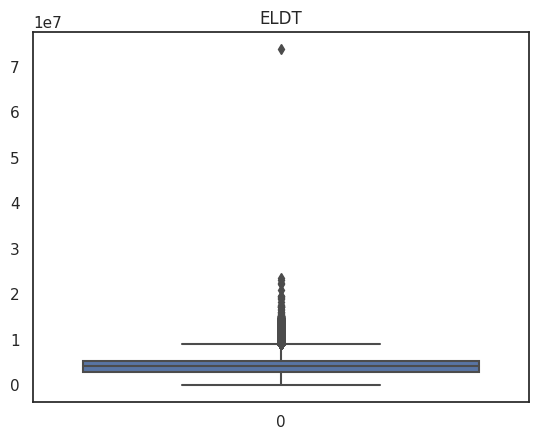

In [281]:
# Boxplot do ELDT
# fig = px.box(BIMTRA_df_adjusted['eldt'], title='ELDT', labels={'value': 'ELDT'}, points='outliers')
# fig.update_traces(dict(marker=dict(size=7,color="darkslategrey"),line=dict(width=1, color="darkslategrey")))
# fig.show()
sns.boxplot(BIMTRA_df_adjusted['eldt'], showfliers=True)

plt.title('ELDT')

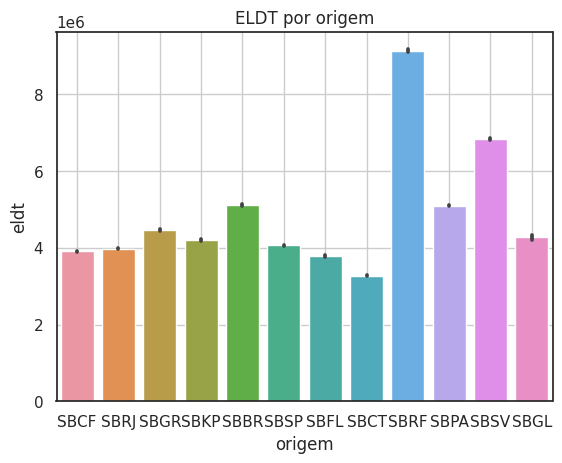

In [282]:
sns.barplot(x=BIMTRA_df_adjusted['origem'], y=BIMTRA_df_adjusted['eldt'])

plt.title('ELDT por origem')
plt.grid(True)

plt.show()

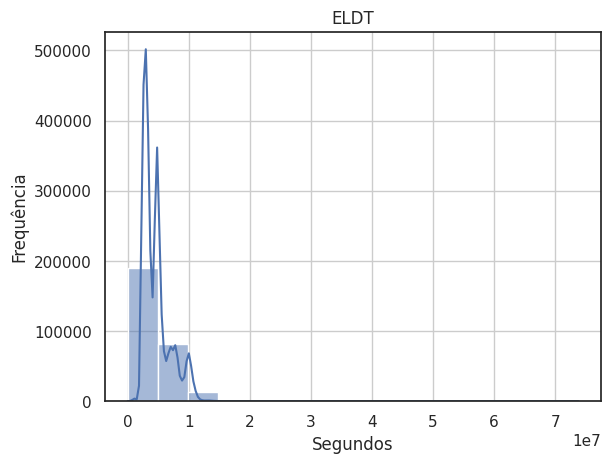

In [283]:
sns.histplot(BIMTRA_df_adjusted['eldt'], bins=15, kde = True)

plt.xlabel('Segundos')
plt.ylabel('Frequência')
plt.title('ELDT')
plt.grid(True)

# Exiba o histograma
plt.show()

<AxesSubplot: >

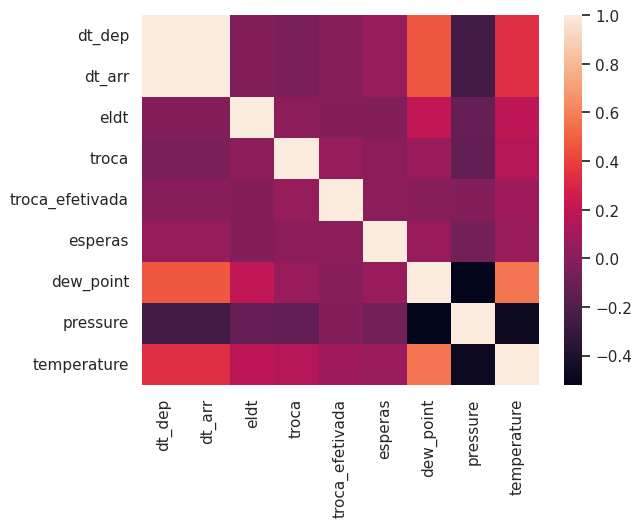

In [320]:
# Correlation matrix
sns.heatmap(df.corr().round(2))

In [284]:
# Agrupar por origem e destino e calcular as estatísticas
impacto_aeroportos = BIMTRA_df_adjusted.groupby(['origem', 'destino']).agg({
    'flightid': 'count',              # Número total de voos
    'eldt': ['mean', 'min', 'max', 'std']  # Estatísticas de tempo de voo
}).reset_index()

# Renomear colunas para maior clareza
impacto_aeroportos.columns = ['Origem', 'Destino', 'Total_Voos', 'Tempo_Médio', 'Tempo_Mínimo', 'Tempo_Máximo', 'Desvio_Padrão']


display(impacto_aeroportos)

,Origem,Destino,Total_Voos,Tempo_Médio,Tempo_Mínimo,Tempo_Máximo,Desvio_Padrão
0,SBBR,SBCF,2984,3.297869e+06,1784000,6171000,283980.815388
1,SBBR,SBCT,1053,5.623611e+06,4999000,7148000,259228.517523
2,SBBR,SBFL,347,6.781703e+06,6020000,11724000,434887.250110
3,SBBR,SBGL,707,4.644405e+06,4043000,7165000,242565.368385
4,SBBR,SBGR,3521,4.670752e+06,3233000,15094000,373911.012005
...,...,...,...,...,...,...,...
133,SBSV,SBKP,1495,7.671552e+06,6563000,14055000,437886.875213
134,SBSV,SBPA,75,1.198772e+07,11010000,13671000,574149.937099
135,SBSV,SBRF,1634,3.815069e+06,3166000,9273000,447333.073153
136,SBSV,SBRJ,1817,6.790697e+06,4774000,16631000,514802.788205


# 3. Pré-processamento

In [285]:
BIMTRA_df_adjusted

,flightid,origem,destino,dt_dep,dt_arr,eldt,hora_ref,hora_tcp,troca,hora_tcr,troca_efetivada,hora_esperas,esperas,dew_point,pressure,temperature,visibility,weather
0,504a62621cd231d6ab67e674ce538cd3,SBCF,SBFL,1654045238000,1654050785000,5547000,2022-06-01 01:00:00,2022-06-01 02:00:00,0.0,2022-06-01 01:00:00,0.0,2022-06-01 00:00:00,0.0,14.0,1018.0,21.0,10000 meters,
1,052050016538ab736a254313ef009a6b,SBRJ,SBCF,1654075204000,1654078210000,3006000,2022-06-01 09:00:00,2022-06-01 10:00:00,0.0,2022-06-01 09:00:00,0.0,2022-06-01 08:00:00,0.0,21.0,1015.0,22.0,greater than 10000 meters,
2,e93e3b8510854a55f195788019b5763b,SBGR,SBPA,1654046445000,1654051465000,5020000,2022-06-01 01:00:00,2022-06-01 02:00:00,0.0,2022-06-01 01:00:00,0.0,2022-06-01 00:00:00,0.0,15.0,1020.0,16.0,greater than 10000 meters,
3,2386fcd950814c8d343d93c4b51585d1,SBGR,SBPA,1654046039000,1654051301000,5262000,2022-06-01 01:00:00,2022-06-01 02:00:00,0.0,2022-06-01 01:00:00,0.0,2022-06-01 00:00:00,0.0,15.0,1020.0,16.0,greater than 10000 meters,
4,f738e67220fcd688fed028a6389891e2,SBKP,SBPA,1654046798000,1654051882000,5084000,2022-06-01 01:00:00,2022-06-01 02:00:00,0.0,2022-06-01 01:00:00,0.0,2022-06-01 00:00:00,0.0,15.0,1018.0,17.0,10000 meters,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286619,c4321a6a09b76969df53965fb5390f12,SBBR,SBRF,1683980059000,1683987623000,7564000,2023-05-13 12:00:00,2023-05-13 13:00:00,0.0,2023-05-13 12:00:00,0.0,2023-05-13 11:00:00,0.0,14.0,1022.0,21.0,10000 meters,
286620,e4f5686cce45083566945c8946e5d120,SBBR,SBGR,1683970395000,1683975521000,5126000,2023-05-13 09:00:00,2023-05-13 10:00:00,0.0,2023-05-13 09:00:00,0.0,2023-05-13 08:00:00,0.0,14.0,1020.0,16.0,10000 meters,
286621,04f65a7c44cf176215520b4c9b4eb37f,SBCF,SBRF,1683996833000,1684004424000,7591000,2023-05-13 16:00:00,2023-05-13 17:00:00,0.0,2023-05-13 16:00:00,0.0,2023-05-13 15:00:00,0.0,14.0,1018.0,26.0,greater than 10000 meters,
286622,f72a0718e581d01c695faeeff35d81f0,SBSV,SBGR,1683955738000,1683964481000,8743000,2023-05-13 05:00:00,2023-05-13 06:00:00,0.0,2023-05-13 05:00:00,0.0,2023-05-13 04:00:00,0.0,25.0,1013.0,26.0,greater than 10000 meters,


In [286]:
BIMTRA_df_encoded = BIMTRA_df_adjusted.copy()

# # One hot encoding das chegadas

# origem = BIMTRA_df_adjusted['origem'].unique()
# origem = pd.get_dummies(origem, prefix='origem')
# BIMTRA_df_encoded = BIMTRA_df_adjusted.join(origem)

# # One hot encoding dos destinos

# destino = BIMTRA_df_encoded['destino'].unique()
# destino = pd.get_dummies(destino, prefix='destino')
# BIMTRA_df_encoded = BIMTRA_df_encoded.join(destino)
# BIMTRA_df_encoded

# BIMTRA_df_encoded.drop(['origem', 'destino'], axis=1, inplace=True)

# Organizando a ordem das colunas
coluna_esperas = BIMTRA_df_encoded.pop('esperas')  # Remove a coluna 'C' do DataFrame
BIMTRA_df_encoded.insert(4, 'esperas', coluna_esperas)  # Insere a coluna 'C' na posição desejada (posição 1 neste caso)

l = list(BIMTRA_df_encoded.columns)
l.remove('eldt')
l.remove('flightid')
l.remove('dt_arr')
l.remove('hora_tcp')
l.remove('hora_tcr')
l.remove('hora_ref')
l.remove('hora_esperas')
''' l.remove('troca')
l.remove('troca_efetivada') '''
''' l.append('troca') '''
l.append('eldt')

BIMTRA_df_encoded = BIMTRA_df_encoded[l]

# Converte variáveis categoricas para o tipo "category" (Requisito pro XGBoost funcionar)
BIMTRA_df_encoded['origem'] = BIMTRA_df_encoded['origem'].astype('category')
BIMTRA_df_encoded['destino'] = BIMTRA_df_encoded['destino'].astype('category')

''' BIMTRA_df_encoded.rename(columns={'troca_efetivada': 'troca'}, inplace=True) '''


BIMTRA_df_encoded

,origem,destino,dt_dep,esperas,troca,troca_efetivada,dew_point,pressure,temperature,visibility,weather,eldt
0,SBCF,SBFL,1654045238000,0.0,0.0,0.0,14.0,1018.0,21.0,10000 meters,,5547000
1,SBRJ,SBCF,1654075204000,0.0,0.0,0.0,21.0,1015.0,22.0,greater than 10000 meters,,3006000
2,SBGR,SBPA,1654046445000,0.0,0.0,0.0,15.0,1020.0,16.0,greater than 10000 meters,,5020000
3,SBGR,SBPA,1654046039000,0.0,0.0,0.0,15.0,1020.0,16.0,greater than 10000 meters,,5262000
4,SBKP,SBPA,1654046798000,0.0,0.0,0.0,15.0,1018.0,17.0,10000 meters,,5084000
...,...,...,...,...,...,...,...,...,...,...,...,...
286619,SBBR,SBRF,1683980059000,0.0,0.0,0.0,14.0,1022.0,21.0,10000 meters,,7564000
286620,SBBR,SBGR,1683970395000,0.0,0.0,0.0,14.0,1020.0,16.0,10000 meters,,5126000
286621,SBCF,SBRF,1683996833000,0.0,0.0,0.0,14.0,1018.0,26.0,greater than 10000 meters,,7591000
286622,SBSV,SBGR,1683955738000,0.0,0.0,0.0,25.0,1013.0,26.0,greater than 10000 meters,,8743000


# 4. Treinamento 

In [287]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(BIMTRA_df_encoded.copy().drop('eldt', axis=1), BIMTRA_df_encoded['eldt'], test_size=0.2)

In [288]:
# reg = xg.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.7467983561008608, gamma=0.02904180608409973, learning_rate=0.28985284373248055, max_depth=5, n_estimators=139, subsample=0.8832290311184181, random_state=42, early_stopping_rounds=10, eval_set=[(X_test, y_test)], enable_categorical=True)
reg = xg.XGBRegressor(
    objective='reg:squarederror',
    colsample_bytree=0.8045997961875188,
    gamma=0.04808827554571038,
    learning_rate=0.31215697934688114,
    max_depth=5,
    n_estimators=138,
    subsample=0.9746919954946938,
    random_state=42,
    enable_categorical=True,
)
reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8045997961875188, device=None,
             early_stopping_rounds=None, enable_categorical=True,
             eval_metric=None, feature_types=None, gamma=0.04808827554571038,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.31215697934688114,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=138, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

## 4.1 Performance do modelo

In [304]:
print("Performance do modelo nos dados de treino: ", str(round(reg.score(X_train, y_train) * 100, 2))+"%")
print("Performance do modelo nos dados de teste: ", str(round(reg.score(X_test, y_test) * 100, 2))+"%")

Performance do modelo nos dados de treino:  96.5%
Performance do modelo nos dados de teste:  96.66%


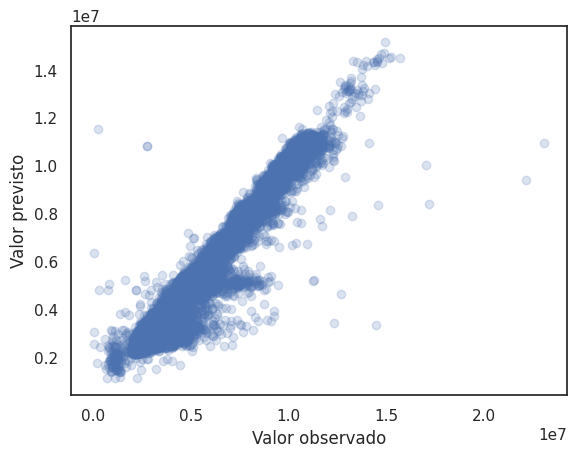

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

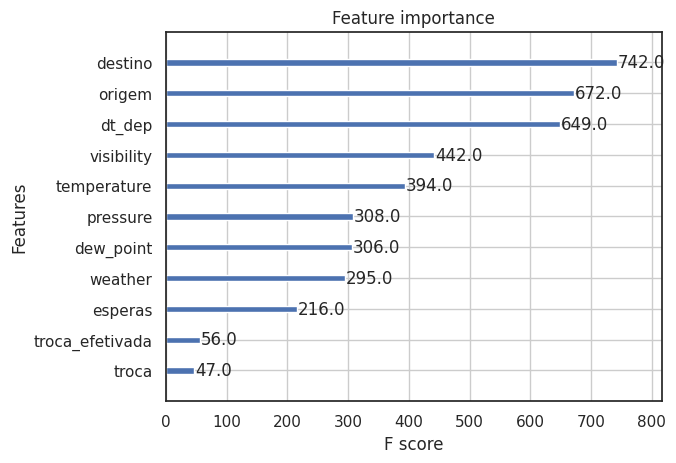

In [305]:
# Previsão
y_pred = reg.predict(X_test)

plt.scatter(y_test, y_pred, alpha=0.2)
plt.xlabel('Valor observado')
plt.ylabel('Valor previsto')
plt.show()

xg.plot_importance(reg)

# fig = px.scatter(x=y_test, y=y_pred)
# fig.update_xaxes(title="Valor observado")
# fig.update_yaxes(title="Valor previsto")

# # Add a title
# fig.update_layout(title="Valor observado vs. Valor previsto")


In [306]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print("Erro Quadrático Médio (MSE): ", mean_squared_error(y_test, y_pred))
print("Erro Absoluto Médio (MAE): ", mean_absolute_error(y_test, y_pred))
print("Raiz do Erro Quadrático Médio (RMSE) : ", np.sqrt(mean_squared_error(y_test, y_pred)))

print("R2: ", r2_score(y_test, y_pred))

Erro Quadrático Médio (MSE):  163486695614.09317
Erro Absoluto Médio (MAE):  244280.4272285464
Raiz do Erro Quadrático Médio (RMSE) :  404334.88053109293
R2:  0.9665944202509601


# 5. Submissão

In [307]:
# Csv de teste do Kaggle
idsc_test = pd.read_csv('idsc_test.csv')
idsc_test

,flightid,origem,destino,dt_dep,hora_ref,snapshot_radar,path,hora_esperas,esperas,aero_esperas,...,metaf,aero_metaf,hora_metar,metar,aero_metar,hora_tcp,troca,aero_tcp,hora_tcr,aero_tcr
0,7945735584a3297121c4f5ae0de8ecd1,SBKP,SBSV,2023-05-30 11:36:03.000,2023-05-30 11:00:00.000,MULTIPOINT ((-0.8807200448127578 -0.5148453155...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-30 10:00:00.000,0,SBSV,...,NaN,NaN,2023-05-30 11:00:00.000,METAR SBSV 301100Z 12009KT 9999 FEW023 28/21 Q...,SBSV,2023-05-30 12:00:00.000,0,SBSV,NaN,NaN
1,85cb958e8b9d583575cd9cb93e389226,SBFL,SBRJ,2023-05-19 08:26:06.000,2023-05-19 08:00:00.000,MULTIPOINT ((-0.8826266039383116 -0.4926305156...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-19 07:00:00.000,0,SBRJ,...,METAF SBRJ 190900Z 33004KT 9999 BKN033 ...,SBRJ,2023-05-19 08:00:00.000,METAR SBRJ 190800Z 02004KT 9999 FEW010 SCT040 ...,SBRJ,2023-05-19 09:00:00.000,0,SBRJ,NaN,NaN
2,2d4e8cd3947525a12ff16af520beefb9,SBCF,SBGR,2023-05-22 11:52:02.000,2023-05-22 11:00:00.000,MULTIPOINT ((-0.8972512464147154 -0.5215196550...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-22 10:00:00.000,0,SBGR,...,METAF SBGR 221200Z 04003KT CAVOK 19/09 Q1021=\n,SBGR,2023-05-22 11:00:00.000,METAR SBGR 221100Z 07006KT CAVOK 13/12 Q1022=,SBGR,2023-05-22 12:00:00.000,0,SBGR,NaN,NaN
3,24cf317a1494a016a018d9f5cd183639,SBFL,SBSP,2023-05-29 16:07:07.000,2023-05-29 16:00:00.000,MULTIPOINT ((-0.892972783728755 -0.51704889771...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-29 15:00:00.000,2,SBSP,...,METAF SBSP 291700Z 15010KT 9999 OVC033 ...,SBSP,2023-05-29 16:00:00.000,METAR SBSP 291600Z 12010KT 090V160 9999 SCT015...,SBSP,2023-05-29 17:00:00.000,0,SBSP,NaN,NaN
4,370babaf32dc82a6a64bf5b71a3434ed,SBCF,SBKP,2023-05-25 22:16:04.000,2023-05-25 22:00:00.000,MULTIPOINT ((-0.8970045369724385 -0.5240544927...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-25 21:00:00.000,0,SBKP,...,METAF SBKP 252300Z 08008KT CAVOK 21/12 Q1019=\n,SBKP,2023-05-25 22:00:00.000,METAR SBKP 252200Z 09004KT CAVOK 23/13 Q1020=,SBKP,2023-05-25 23:00:00.000,0,SBKP,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,6f6d576aafbd90e308a848a060395e9a,SBPA,SBGR,2023-05-19 22:02:03.000,2023-05-19 22:00:00.000,MULTIPOINT ((-0.8891070333352145 -0.5128856751...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-19 21:00:00.000,0,SBGR,...,METAF SBGR 192300Z 11006KT 9000 FEW019 ...,SBGR,2023-05-19 22:00:00.000,METAR SBGR 192200Z 14003KT CAVOK 16/13 Q1021=,SBGR,2023-05-19 23:00:00.000,0,SBGR,NaN,NaN
96,20055ed6ecea5e916923081fc3b049f7,SBCF,SBKP,2023-05-31 19:54:04.000,2023-05-31 19:00:00.000,MULTIPOINT ((-0.8887839089364267 -0.5156303040...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-31 18:00:00.000,0,SBKP,...,METAF SBKP 312000Z 23006KT 9999 OVC022 ...,SBKP,2023-05-31 19:00:00.000,METAR SBKP 311900Z 24005KT 5000 2000S -RA BR B...,SBKP,2023-05-31 20:00:00.000,0,SBKP,2023-05-31 19:00:00.000,SBKP
97,c5e4e8d78906ae2b3218847cc9f045d9,SBSP,SBRJ,2023-05-20 15:16:05.000,2023-05-20 15:00:00.000,MULTIPOINT ((-0.8916331377478003 -0.5089690765...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-20 14:00:00.000,0,SBRJ,...,METAF SBRJ 201600Z 10003KT 9999 FEW033 ...,SBRJ,2023-05-20 15:00:00.000,METAR SBRJ 201500Z 34003KT 250V040 CAVOK 23/16...,SBRJ,2023-05-20 16:00:00.000,0,SBRJ,NaN,NaN
98,878ad3e9104c78f2945f6194c2d883ce,SBBR,SBSP,2023-05-31 11:31:02.000,2023-05-31 11:00:00.000,MULTIPOINT ((-0.8987280459174578 -0.5209708603...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-31 10:00:00.000,0,SBSP,...,METAF SBSP 311200Z 07006KT 6000 - RA OVC026 ...,SBSP,2023-05-31 11:00:00.000,METAR SBSP 311100Z 08006KT 020V120 4000 -RA BR...,SBSP,2023-05-31 12:00:00.000,0,SBSP,NaN,NaN


Tratar dados cabeceiras

In [308]:
idsc_test.rename(columns={'aero_tcr': 'troca_efetivada'}, inplace=True)
idsc_test['troca_efetivada'] = idsc_test['troca_efetivada'].apply(lambda x: 0 if pd.isna(x) else 1)
idsc_test


,flightid,origem,destino,dt_dep,hora_ref,snapshot_radar,path,hora_esperas,esperas,aero_esperas,...,metaf,aero_metaf,hora_metar,metar,aero_metar,hora_tcp,troca,aero_tcp,hora_tcr,troca_efetivada
0,7945735584a3297121c4f5ae0de8ecd1,SBKP,SBSV,2023-05-30 11:36:03.000,2023-05-30 11:00:00.000,MULTIPOINT ((-0.8807200448127578 -0.5148453155...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-30 10:00:00.000,0,SBSV,...,NaN,NaN,2023-05-30 11:00:00.000,METAR SBSV 301100Z 12009KT 9999 FEW023 28/21 Q...,SBSV,2023-05-30 12:00:00.000,0,SBSV,NaN,0
1,85cb958e8b9d583575cd9cb93e389226,SBFL,SBRJ,2023-05-19 08:26:06.000,2023-05-19 08:00:00.000,MULTIPOINT ((-0.8826266039383116 -0.4926305156...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-19 07:00:00.000,0,SBRJ,...,METAF SBRJ 190900Z 33004KT 9999 BKN033 ...,SBRJ,2023-05-19 08:00:00.000,METAR SBRJ 190800Z 02004KT 9999 FEW010 SCT040 ...,SBRJ,2023-05-19 09:00:00.000,0,SBRJ,NaN,0
2,2d4e8cd3947525a12ff16af520beefb9,SBCF,SBGR,2023-05-22 11:52:02.000,2023-05-22 11:00:00.000,MULTIPOINT ((-0.8972512464147154 -0.5215196550...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-22 10:00:00.000,0,SBGR,...,METAF SBGR 221200Z 04003KT CAVOK 19/09 Q1021=\n,SBGR,2023-05-22 11:00:00.000,METAR SBGR 221100Z 07006KT CAVOK 13/12 Q1022=,SBGR,2023-05-22 12:00:00.000,0,SBGR,NaN,0
3,24cf317a1494a016a018d9f5cd183639,SBFL,SBSP,2023-05-29 16:07:07.000,2023-05-29 16:00:00.000,MULTIPOINT ((-0.892972783728755 -0.51704889771...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-29 15:00:00.000,2,SBSP,...,METAF SBSP 291700Z 15010KT 9999 OVC033 ...,SBSP,2023-05-29 16:00:00.000,METAR SBSP 291600Z 12010KT 090V160 9999 SCT015...,SBSP,2023-05-29 17:00:00.000,0,SBSP,NaN,0
4,370babaf32dc82a6a64bf5b71a3434ed,SBCF,SBKP,2023-05-25 22:16:04.000,2023-05-25 22:00:00.000,MULTIPOINT ((-0.8970045369724385 -0.5240544927...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-25 21:00:00.000,0,SBKP,...,METAF SBKP 252300Z 08008KT CAVOK 21/12 Q1019=\n,SBKP,2023-05-25 22:00:00.000,METAR SBKP 252200Z 09004KT CAVOK 23/13 Q1020=,SBKP,2023-05-25 23:00:00.000,0,SBKP,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,6f6d576aafbd90e308a848a060395e9a,SBPA,SBGR,2023-05-19 22:02:03.000,2023-05-19 22:00:00.000,MULTIPOINT ((-0.8891070333352145 -0.5128856751...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-19 21:00:00.000,0,SBGR,...,METAF SBGR 192300Z 11006KT 9000 FEW019 ...,SBGR,2023-05-19 22:00:00.000,METAR SBGR 192200Z 14003KT CAVOK 16/13 Q1021=,SBGR,2023-05-19 23:00:00.000,0,SBGR,NaN,0
96,20055ed6ecea5e916923081fc3b049f7,SBCF,SBKP,2023-05-31 19:54:04.000,2023-05-31 19:00:00.000,MULTIPOINT ((-0.8887839089364267 -0.5156303040...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-31 18:00:00.000,0,SBKP,...,METAF SBKP 312000Z 23006KT 9999 OVC022 ...,SBKP,2023-05-31 19:00:00.000,METAR SBKP 311900Z 24005KT 5000 2000S -RA BR B...,SBKP,2023-05-31 20:00:00.000,0,SBKP,2023-05-31 19:00:00.000,1
97,c5e4e8d78906ae2b3218847cc9f045d9,SBSP,SBRJ,2023-05-20 15:16:05.000,2023-05-20 15:00:00.000,MULTIPOINT ((-0.8916331377478003 -0.5089690765...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-20 14:00:00.000,0,SBRJ,...,METAF SBRJ 201600Z 10003KT 9999 FEW033 ...,SBRJ,2023-05-20 15:00:00.000,METAR SBRJ 201500Z 34003KT 250V040 CAVOK 23/16...,SBRJ,2023-05-20 16:00:00.000,0,SBRJ,NaN,0
98,878ad3e9104c78f2945f6194c2d883ce,SBBR,SBSP,2023-05-31 11:31:02.000,2023-05-31 11:00:00.000,MULTIPOINT ((-0.8987280459174578 -0.5209708603...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-31 10:00:00.000,0,SBSP,...,METAF SBSP 311200Z 07006KT 6000 - RA OVC026 ...,SBSP,2023-05-31 11:00:00.000,METAR SBSP 311100Z 08006KT 020V120 4000 -RA BR...,SBSP,2023-05-31 12:00:00.000,0,SBSP,NaN,0


Tratar dados metar

In [309]:
metar_columns_sub = get_all_metar_data(idsc_test['metar'])

metar_columns_sub

-----------------------------------------------------------------------
METAR:  METAR SBSV 301100Z 12009KT 9999 FEW023 28/21 Q1019=
-----------------------------------------------------------------------
-----------------------------------------------------------------------
METAR:  METAR SBRJ 190800Z 02004KT 9999 FEW010 SCT040 BKN050 19/17 Q1019=
-----------------------------------------------------------------------
-----------------------------------------------------------------------
METAR:  METAR SBGR 221100Z 07006KT CAVOK 13/12 Q1022=
-----------------------------------------------------------------------
-----------------------------------------------------------------------
METAR:  METAR SBSP 291600Z 12010KT 090V160 9999 SCT015 SCT019 19/14 Q1023=
-----------------------------------------------------------------------
-----------------------------------------------------------------------
METAR:  METAR SBKP 252200Z 09004KT CAVOK 23/13 Q1020=
-----------------------------------

,aeroporto,dew_point,pressure,report_type,sky,temperature,time,visibility,weather,wind,visual_range
0,SBSV,21.0 C,1019.0 mb,"routine report, cycle 11 (automatic report)",a few clouds at 2300 feet,28.0 C,Wed Aug 30 11:00:00 2023,greater than 10000 meters,,ESE at 9 knots,NaN
1,SBRJ,17.0 C,1019.0 mb,"routine report, cycle 8 (automatic report)",a few clouds at 1000 feet\n scattered clou...,19.0 C,Tue Sep 19 08:00:00 2023,greater than 10000 meters,,NNE at 4 knots,NaN
2,SBGR,12.0 C,1022.0 mb,"routine report, cycle 11 (automatic report)",,13.0 C,Fri Sep 22 11:00:00 2023,10000 meters,,ENE at 6 knots,NaN
3,SBSP,14.0 C,1023.0 mb,"routine report, cycle 16 (automatic report)",scattered clouds at 1500 feet\n scattered ...,19.0 C,Tue Aug 29 16:00:00 2023,greater than 10000 meters,,E to SSE at 10 knots,NaN
4,SBKP,13.0 C,1020.0 mb,"routine report, cycle 22 (automatic report)",,23.0 C,Fri Aug 25 22:00:00 2023,10000 meters,,E at 4 knots,NaN
...,...,...,...,...,...,...,...,...,...,...,...
95,SBGR,13.0 C,1021.0 mb,"routine report, cycle 22 (automatic report)",,16.0 C,Tue Sep 19 22:00:00 2023,10000 meters,,SE at 3 knots,NaN
96,SBKP,17.0 C,1020.0 mb,"routine report, cycle 19 (automatic report)",broken clouds at 700 feet\n overcast at 30...,18.0 C,Thu Aug 31 19:00:00 2023,5000 meters; 2000 meters to S,light rain; mist,WSW at 5 knots,NaN
97,SBRJ,16.0 C,1019.0 mb,"routine report, cycle 15 (automatic report)",,23.0 C,Wed Sep 20 15:00:00 2023,10000 meters,,WSW to NE at 3 knots,NaN
98,SBSP,15.0 C,1022.0 mb,"routine report, cycle 11 (automatic report)",broken clouds at 500 feet\n overcast at 70...,15.0 C,Thu Aug 31 11:00:00 2023,4000 meters,light rain; mist,NNE to ESE at 6 knots,NaN


In [310]:
metar_to_merge_sub = get_columns_metar(metar_columns_sub)

metar_to_merge_sub

,dew_point,pressure,temperature,visibility,weather
0,21.0,1019.0,28.0,greater than 10000 meters,
1,17.0,1019.0,19.0,greater than 10000 meters,
2,12.0,1022.0,13.0,10000 meters,
3,14.0,1023.0,19.0,greater than 10000 meters,
4,13.0,1020.0,23.0,10000 meters,
...,...,...,...,...,...
95,13.0,1021.0,16.0,10000 meters,
96,17.0,1020.0,18.0,5000 meters; 2000 meters to S,light rain; mist
97,16.0,1019.0,23.0,10000 meters,
98,15.0,1022.0,15.0,4000 meters,light rain; mist


In [311]:
idsc_test = pd.concat([idsc_test, metar_to_merge_sub], axis=1)

In [312]:
idsc_test_encoded.columns

Index(['origem', 'destino', 'dt_dep', 'esperas', 'troca', 'troca_efetivada',
       'dew_point', 'pressure', 'temperature', 'visibility', 'weather'],
      dtype='object')

In [313]:
BIMTRA_df_encoded.columns

Index(['origem', 'destino', 'dt_dep', 'esperas', 'troca', 'troca_efetivada',
       'dew_point', 'pressure', 'temperature', 'visibility', 'weather',
       'eldt'],
      dtype='object')

In [314]:
idsc_test_encoded = idsc_test.copy()

# Organizando as colunas
l = list(idsc_test_encoded.columns)
l.remove('flightid')
idsc_test_encoded = idsc_test_encoded[l]

filtro = pd.Series(idsc_test_encoded.columns)
filtro = filtro[filtro.isin(BIMTRA_df_encoded.columns)]
idsc_test_encoded = idsc_test_encoded[filtro]

# Converte data e hora para o tipo milissegundos desde 1970
datetime_to_int64(idsc_test_encoded, 'dt_dep')


# Converte variáveis categoricas para o tipo "category" (Requisito pro XGBoost funcionar)
idsc_test_encoded['origem'] = idsc_test_encoded['origem'].astype('category')
idsc_test_encoded['destino'] = idsc_test_encoded['destino'].astype('category')

idsc_test_encoded

,origem,destino,dt_dep,esperas,troca,troca_efetivada,dew_point,pressure,temperature,visibility,weather
0,SBKP,SBSV,1.685447e+12,0,0,0,21.0,1019.0,28.0,greater than 10000 meters,
1,SBFL,SBRJ,1.684485e+12,0,0,0,17.0,1019.0,19.0,greater than 10000 meters,
2,SBCF,SBGR,1.684756e+12,0,0,0,12.0,1022.0,13.0,10000 meters,
3,SBFL,SBSP,1.685376e+12,2,0,0,14.0,1023.0,19.0,greater than 10000 meters,
4,SBCF,SBKP,1.685053e+12,0,0,0,13.0,1020.0,23.0,10000 meters,
...,...,...,...,...,...,...,...,...,...,...,...
95,SBPA,SBGR,1.684534e+12,0,0,0,13.0,1021.0,16.0,10000 meters,
96,SBCF,SBKP,1.685563e+12,0,0,1,17.0,1020.0,18.0,5000 meters; 2000 meters to S,light rain; mist
97,SBSP,SBRJ,1.684596e+12,0,0,0,16.0,1019.0,23.0,10000 meters,
98,SBBR,SBSP,1.685533e+12,0,0,0,15.0,1022.0,15.0,4000 meters,light rain; mist


In [315]:
# Prediz os valores
y_pred = reg.predict(idsc_test_encoded)
data_in_seconds = y_pred / 1000.0

# Criar um DataFrame com a coluna de dados em segundos
y_pred = pd.DataFrame(data_in_seconds)

y_pred

,0
0,6842.097656
1,4205.986328
2,3474.173828
3,3416.660645
4,3224.203369
...,...
95,5140.501465
96,3393.862549
97,2470.044189
98,5679.737793


In [316]:
sumbission = pd.DataFrame()
sumbission['ID'] = idsc_test['flightid']
sumbission['solution'] = y_pred

sumbission.to_csv('submission.csv', index=False)

In [317]:
sumbission

,ID,solution
0,7945735584a3297121c4f5ae0de8ecd1,6842.097656
1,85cb958e8b9d583575cd9cb93e389226,4205.986328
2,2d4e8cd3947525a12ff16af520beefb9,3474.173828
3,24cf317a1494a016a018d9f5cd183639,3416.660645
4,370babaf32dc82a6a64bf5b71a3434ed,3224.203369
...,...,...
95,6f6d576aafbd90e308a848a060395e9a,5140.501465
96,20055ed6ecea5e916923081fc3b049f7,3393.862549
97,c5e4e8d78906ae2b3218847cc9f045d9,2470.044189
98,878ad3e9104c78f2945f6194c2d883ce,5679.737793


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=4ef28bfa-f18c-417e-93b5-8e27cf9bc92e' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>